In [35]:
using Plots
using StatsBase
using Distributions
using Random
using QuadGK
using LinearAlgebra
using Combinatorics
using BenchmarkTools
using Printf
using Parameters

#include("MyModuleILM.jl")
#import .MyModuleILM

include("../matrices/matrix.jl")
include("../instantonDensity/iDensity.jl")
include("../action/actions.jl")
include("../fermionDet/fermionDets.jl")
include("../HMC/HMCs.jl")



#versioninfo()

CalForce (generic function with 1 method)

In [36]:
#行列とトレース，行列式に関する公式の確認

TestA = [
    1 2
    3 4
]

TestB = [
    0 3+2im
    3-2im 0
]

TestC = exp(TestB)

@show det(TestB)
@show tr(log(TestB))
@show log(abs(det(TestB)))
@show exp(log(abs(det(TestB))))
@show exp(tr(log(TestB)))


@show log(im) == pi * im/2

det(TestB) = -13.0 - 0.0im
tr(log(TestB)) = 2.5649493574615363 + 3.1415926535897927im
log(abs(det(TestB))) = 2.5649493574615367
exp(log(abs(det(TestB)))) = 13.0
exp(tr(log(TestB))) = -12.999999999999995 + 7.365200566942371e-15im
log(im) == (pi * im) / 2 = true


true

$$
\det (e^A) = e^{\textrm{tr} A} \\
\det (A) = e^{\textrm{tr}(\log A)} \\
\textrm{tr}(\log A) = \log (\det (A))
$$

$$
6 \int_0^{\infty} \frac{x^{3/2}}{(x+1/\lambda)^{3/2}(x+\lambda)^{5/2}}dx 
= \frac{3 \pi}{8} \frac{\lambda^{3/2}}{[1+\frac{5}{4}(\lambda^2-1) + (3\pi/32)^{4/3}(\lambda^2-1)^2]^{3/4}}
$$

In [65]:
# model parameters
Nc = 3
Nf = 0
Λ  = 270 #MeV

#=
---number of instantons---
インスタントンと反インスタントンの数を指定する．
多くの場合は nI = nA としたQ=0の場合を考えているが，
U(1)Aアノマリーを考える場合にはこの条件を外す必要があるかもしれない．
（要検討）
=#
nI = 3
nA = 3
N  = nI+nA

#=
---size of instantons---
インスタントンサイズの初期値は適当な値で初期化しておく．
インスタントン+反インスタントンの数だけ用意する．
これは集団座標なのでモンテカルロ法で積分される自由度．
=#
mag = 0.7
ρ   = (1/Λ)* mag * ones(Float64,nI+nA)
@printf("ρ_ini = %5.4f fm\n",(1/Λ)* 197 * mag)

#=
---color parameters of instantons---
インスタントンのSU(N)color行列を決めるcolor parameters
SU(N)に対して N²-1 個のパラメータを基本的には用意する．
ただし，SU(3)の場合は N²-1=8 ではなく，模型のスケール不変性から
自由度が1つ減少するので 7 とする．（要確認）

パラメータを用いる際は，[0:2pi] の一様乱数で初期化して用いる:
code : rand!(Uniform(0,2pi),θI)
=#
θ  = zeros(Float64,nI+nA,Nc)
rand!(Uniform(0,2pi),θ)

#=
インスタントンと反インスタントンの時空座標．
モンテカルロ法で積分される自由度．

横方向:インスタントン，反インスタントンの添字．
縦方向:時空の添字．

ex)  z[2,3]  -> 全体で２番目のインスタントンのz₃=z座標 

=#
z  = ones(Float64,nI+nA,4) 
rand!(z)

#=
color vectorを計算するために必要なパラメータ
=#
u      = zeros(ComplexF64,4)         #color vector
Sigma  = make_sigma()                #Pauli行列を生成
@show typeof(Sigma)
@show typeof(Sigma[1])
Lambda = make_lambda()               #Gell-Mann行列を生成
tem    = similar(Sigma[1])           #color vectorを計算するために必要なワークスペース#1
res    = similar(Sigma[1])           #color vectorを計算するために必要なワークスペース#2
dynamical_q = (u, Sigma, tem, res)   #color vectorを計算するために必要なパラメータ

A  = 128.0                           #相互作用の強さを決めるパラメータ
g  = 1.0                             #coupling constant

p           = (Nc,Nf,Λ,nI,nA)        #モデルパラメータ
dynamical_p = (ρ, z, θ, A, g)        #力学的自由度を持つパラメータ


#--------------------------------------------------------------------------------------------------------#
#= HMC法の計算を実行する． =#




#----------------------------------------------------------------------------------------------------------#
#IAペアに対して作用の計算を実行する．

Sint = 0.0 
@time S_interaction!(Sint,p,dynamical_p,dynamical_q)


ρ_ini = 0.5107 fm
typeof(Sigma) = Vector{Any}
typeof(Sigma[1]) = Matrix{ComplexF64}
  0.000968 seconds (1.45 k allocations: 155.094 KiB)


-2.7207604724838193e-9 + 0.0im

In [4]:
#-----------------------------------------------------------------------------------------------------------------------#
#= HMC法の計算を実行する． =#

using Parameters
using Distributions
using Random
using LinearAlgebra
using Combinatorics

include("../matrices/matrix.jl")
include("../instantonDensity/iDensity.jl")
include("../action/actions.jl")
include("../fermionDet/fermionDets.jl")
include("../HMC/HMCs.jl")

# model parameters -----------------------------------------------------------------------------------------------------#
modelparams = ModelParams(0,0,0,  0,0,0,  0,0,0, "gauge")                   #struct呼び出し
ChooseGaugeField!(modelparams,1,2,gauge="SU(2)",flavor=1)  #インスタントン数，ゲージ場のカラー，フレーバー数の選択


#カラー空間での計算を行うワークスペースの確保
@with_kw mutable struct ColorWorkSpace
    u::Array{ComplexF64,1}   = zeros(ComplexF64,4)
    sigma::Array{Any,1}      = MakeSigma()
    lambda::Array{Any,1}     = MakeLambda()
    tem::Array{ComplexF64,2} = zeros(ComplexF64,2,2)
    res::Array{ComplexF64,2} = zeros(ComplexF64,2,2)
end

#初期配位，共役運動量の初期化 -----------------------------------------------------------------------------------------------#
@with_kw mutable struct ParamsofILM
    ρ::Array{Float64,1}     = (1/modelparams.Λ)* modelparams.mag * ones(Float64, modelparams.nI + modelparams.nA)
    θ::Array{Float64,2}     = rand(Float64, modelparams.nI + modelparams.nA, modelparams.Nc)
    z::Array{Float64,2}     = ones(Float64,  modelparams.nI + modelparams.nA, 4) 
    conjρ::Array{Float64,1} = rand(Normal(0,1), modelparams.nI + modelparams.nA)
    conjθ::Array{Float64,2} = rand(Normal(0,1), modelparams.nI + modelparams.nA, modelparams.Nc)
    conjz::Array{Float64,2} = rand(Normal(0,1), modelparams.nI + modelparams.nA, 4)
end

ParamsofHMC = ParamsofILM()
colorworkspace = ColorWorkSpace()
# Sigma  :OK
# u      :OK
# lambda :OK
# tem    :OK
# res    :OK
# lambda :OK
# theta  :OK



#conjρの出力確認
#=
@show ParamsofHMC.conjρ[1]
@show ParamsofHMC.conjρ[2]
@show ParamsofHMC.conjρ[3]
@show ParamsofHMC.conjρ[4]
=#

#conjθの出力確認
#=
@show ParamsofHMC.conjθ[1, 1]
@show ParamsofHMC.conjθ[1, 2]
@show ParamsofHMC.conjθ[1, 3]
@show ParamsofHMC.conjθ[2, 1]
@show ParamsofHMC.conjθ[2, 2]
@show ParamsofHMC.conjθ[2, 3]
@show ParamsofHMC.conjθ[3, 1]
@show ParamsofHMC.conjθ[3, 2]
@show ParamsofHMC.conjθ[3, 3]
=#

#=
@show ParamsofHMC.conjθ[4,1:3]
@show dot(ParamsofHMC.conjθ[4,1:3],ParamsofHMC.conjθ[4,1:3])
@show dot(ParamsofHMC.conjθ[4,1:3],ParamsofHMC.conjθ[4,1:3]) == ParamsofHMC.conjθ[4,1]*ParamsofHMC.conjθ[4,1] + ParamsofHMC.conjθ[4,2]*ParamsofHMC.conjθ[4,2] + ParamsofHMC.conjθ[4,3]*ParamsofHMC.conjθ[4,3]

@show ParamsofHMC.conjθ
=#
#=
@show ParamsofHMC.conjz[1]
@show ParamsofHMC.conjz
=#



#初期時刻 tau = 0.0 でのハミルトニアンを計算 ----------------------------------------------------------------------------------#

@time Hamiltonian(ParamsofHMC,modelparams,colorworkspace)

#-------------------------------------------------------------------------------------------------------------------------#


----- Parameters Info. ---------------------------------------------
             Nc : 3
             Nf : 1
              Λ : 270 [MeV]
    Instanton # : 1
AntiInstanton # : 2
          Gauge : SU(2)
--------------------------------------------------------------------
----- Hamiltonian Calc. --------------------------------------------
test(1) passed!
sumMomentum = 10.438497017545904
test (2) passed!
sumAction = -92.71888584826357
Density part passed!
term1 = (-4 * ((1 - λ ^ 4) + (4 * λ ^ 2) * log(λ))) * (dot(u, u) - 4 * abs(sum(u .* R)) ^ 2) = NaN - 0.0im
term2 = 2 * ((1 - λ ^ 2) + (1 + λ ^ 2) * log(λ)) = 0.0
term3 = (dot(u, u) - 4 * abs(sum(u .* R)) ^ 2) ^ 2 + dot(u, u) ^ 2 + 2 * dot(u', u) * dot(u, u') = NaN + NaN*im
s_int = ((term1 + term2 * term3) * 4) / (λ ^ 2 - 1) ^ 3 = NaN + NaN*im
term1 = (-4 * ((1 - λ ^ 4) + (4 * λ ^ 2) * log(λ))) * (dot(u, u) - 4 * abs(sum(u .* R)) ^ 2) = NaN - 0.0im
term2 = 2 * ((1 - λ ^ 2) + (1 + λ ^ 2) * log(λ)) = 0.0
term3 = (dot(u, u) - 4 * abs(sum(u .

NaN + NaN*im

In [ ]:
#２乗和の計算は何が速いか

#LinearAlgebra の dot( , ) が一番速い

using LinearAlgebra

function SumTest1(A)
    sum(A[i]*A[i] for i in eachindex(A))
end

function SumTest2(A)
    sum(A .* A)
end

sq(x) = x^2
function sumTest3(A)
    sum(sq,A)
end

A = ones(5)
B = [1 1 1]

#=
@time SumTest1(A)

@time SumTest2(A)

@time sumTest3(A)

@time sum(A .* A)

@time dot(A,A)
=#

#更新和の計算は何が速いか

x = 0.0
y = 3.9
z = 0.0

function sumAB(A,B)
    A + B
end

@time z += y
@time sumAB(z,y)




  0.000005 seconds (1 allocation: 16 bytes)
  0.002636 seconds (738 allocations: 52.753 KiB, 97.22% compilation time)


7.8

plot_su2I = plot_θ[1, 1:3] = [1.0, 1.0, 1.0]
plot_su2J = plot_θ[2, 1:3] = [1.0, 1.0, 1.0]


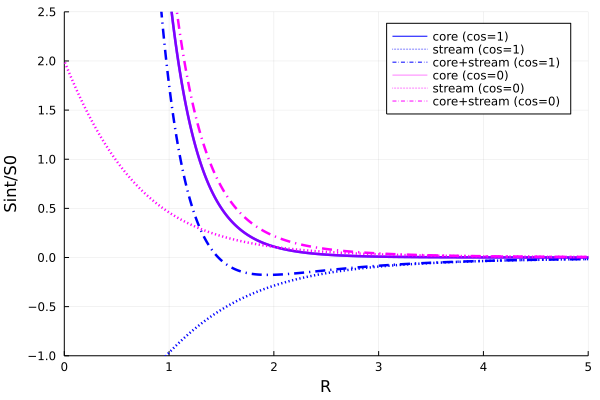

In [ ]:
#S_core,S_stream,S_core+S_streamをプロットする

function dis(z)
    dum = 0.0
    dum = sum( (z[1,i]-z[2,i])^2 for i=1:4)
    return sqrt(dum)
end

function set_z!(i,z,N)
    z[2,4] = 0.0+(6.0/N)*i
end

#plot用の別のパラメータセット
A        = 128
g        = 1
plot_N   = 2
plot_rho = ones(Float64,plot_N)
plot_z   = zeros(Float64,plot_N,4)
plot_θ   = ones(Float64,plot_N,Nc)
#rand!(Uniform(0,2pi),plot_θ)
@show plot_su2I = plot_θ[1, 1:3] # SU(2)の場合
@show plot_su2J = plot_θ[2, 1:3] # SU(2)の場合

u      = zeros(ComplexF64,4)         #color vector
Sigma  = make_sigma()                #Pauli行列を生成
Lambda = make_lambda()               #Gell-Mann行列を生成
tem    = similar(Sigma[1])           #color vectorを計算するために必要なワークスペース#1
res    = similar(Sigma[1])           #color vectorを計算するために必要なワークスペース#2

#plot_prm_p = (plot_rho, plot_z, plot_θ, A, g) 
#plot_prm_q = (u, Sigma, tem, res)


plot_number = 1000
plot_R      = zeros(plot_number)
plot_S_core1 = similar(plot_R)
plot_S_stre1 = similar(plot_R)
plot_S_sum1  = similar(plot_R)
plot_S_core2 = similar(plot_R)
plot_S_stre2 = similar(plot_R)
plot_S_sum2  = similar(plot_R)

#=  plot1 =#
for i=1:plot_number
    plot_su2I = [1,1,1]
    plot_su2J = [1,1,1]
    set_z!(i,plot_z,plot_number)
    #plot_z[2,3] = 0.0+(6.0/plot_number)*i

    plot_prm_p = (plot_rho, plot_z, plot_θ, A, g) 
    plot_prm_q = (u, Sigma, tem, res)

    plot_R[i] = dis(plot_z)
    u         = color_vector(plot_su2I,plot_su2J,plot_prm_q)
    R_hat     = relative_vector(1,2,plot_z)
    nume      = abs(sum(u .* R_hat))
    deno      = sqrt(dot(u,u))
    rel_cos   = nume/deno

    plot_S_core1[i] = S_core(1,2,plot_prm_p,plot_prm_q)
    plot_S_stre1[i] = S_stream(1,2,plot_prm_p,plot_prm_q)
    plot_S_sum1[i]  = S_core(1,2,plot_prm_p,plot_prm_q) + S_stream(1,2,plot_prm_p,plot_prm_q) 
end

plot(plot_R,plot_S_core1,xlim=(0,5),ylim=(-1,2.5),label="core (cos=1)",
    lw=2.5,lc=:blue,ls=:solid,xlabel="R",ylabel="Sint/S0"
)
plot!(plot_R,plot_S_stre1,label="stream (cos=1)",
    lw=2.5,lc=:blue,ls=:dot
)
plot!(plot_R,plot_S_sum1,label="core+stream (cos=1)",
    lw=2.5,lc=:blue,ls=:dashdot
)

#plot(plot_R,plot_DetSL2)

#-----------------------------------------------------------------------------------------------------------------------------------

#plot用の別のパラメータセット
A        = 128
g        = 1
plot_N   = 2
plot_rho = ones(Float64,plot_N)
plot_z   = zeros(Float64,plot_N,4)
plot_θ   = ones(Float64,plot_N,Nc)
#rand!(Uniform(0,2pi),plot_θ)

#@show plot_su2I = plot_θ[1, 1:3] # SU(2)の場合
#@show plot_su2J = plot_θ[2, 1:3] # SU(2)の場合

u      = zeros(ComplexF64,4)         #color vector
Sigma  = make_sigma()                #Pauli行列を生成
Lambda = make_lambda()               #Gell-Mann行列を生成
tem    = similar(Sigma[1])           #color vectorを計算するために必要なワークスペース#1
res    = similar(Sigma[1])           #color vectorを計算するために必要なワークスペース#2

#plot_prm_p = (plot_rho, plot_z, plot_θ, A, g) 
#plot_prm_q = (u, Sigma, tem, res)


plot_number = 1000
plot_R      = zeros(plot_number)
plot_S_core1 = similar(plot_R)
plot_S_stre1 = similar(plot_R)
plot_S_sum1  = similar(plot_R)
plot_S_core2 = similar(plot_R)
plot_S_stre2 = similar(plot_R)

#=  plot2 =#

for i=1:plot_number
    plot_su2I = [1,1,1]
    plot_su2J = [1,1,1]
    #set_z!(i,plot_z,plot_number)
    plot_z[2,3] = 0.0+(6.0/plot_number)*i

    plot_prm_p = (plot_rho, plot_z, plot_θ, A, g) 
    plot_prm_q = (u, Sigma, tem, res)

    plot_R[i] = dis(plot_z)
    #cal cos
    u         = color_vector(plot_su2I,plot_su2J,plot_prm_q)
    R_hat     = relative_vector(1,2,plot_z)
    nume      = abs(sum(u .* R_hat))
    deno      = sqrt(dot(u,u))
    #@show rel_cos   = nume/deno

    plot_S_core2[i] = S_core(1,2,plot_prm_p,plot_prm_q)
    plot_S_stre2[i] = S_stream(1,2,plot_prm_p,plot_prm_q)
    plot_S_sum2[i]  = S_core(1,2,plot_prm_p,plot_prm_q) + S_stream(1,2,plot_prm_p,plot_prm_q) 
end

plot!(plot_R,plot_S_core2,xlim=(0,5),ylim=(-1,2.5),label="core (cos=0)",
    lw=2.5,lc=:magenta,ls=:solid, alpha=0.5
)
plot!(plot_R,plot_S_stre2,label="stream (cos=0)",
    lw=2.5,lc=:magenta,ls=:dot
)
plot!(plot_R,plot_S_sum2,label="core+stream (cos=0)",
    lw=2.5,lc=:magenta,ls=:dashdot
)


#savefig("../FIGS/Sinteraction.pdf")

GeometMean = 1.0
findmax(plot_Error) = (1.1328258796287598e277, 962)
findmin(plot_TrPart) = (6.772506055990173e-154, 90)
findmax(plot_TrPart) = (1.1307188273377534e277, 122)
findmax(plot_IntegError) = (1.1328258796287598e277, 13)
findmin(plot_IntegError) = (7.41446137839104e-260, 3)


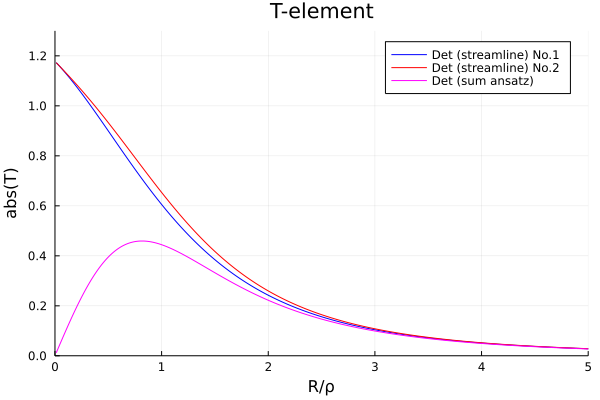

In [ ]:
#DetStreamlineをプロットする．

function dis(z)
    dum = 0.0
    dum = sum( (z[1,i]-z[2,i])^2 for i=1:4)
    return sqrt(dum)
end

function set_z!(i,z,N)
    z[2,4] = 0.0+(12.0/N)*i
end

#plot用の別のパラメータセット
A        = 128
g        = 1
plot_N   = 2
#plot_rho = 2*ones(Float64,plot_N)
plot_rho = [1 1]
plot_z   = zeros(Float64,plot_N,4)
plot_θ   = ones(Float64,plot_N,Nc)
#rand!(Uniform(0,2pi),plot_θ)
plot_su2I = plot_θ[1, 1:3] # SU(2)の場合
plot_su2J = plot_θ[2, 1:3] # SU(2)の場合
#@show plot_su2I
#@show plot_su2J

u      = zeros(ComplexF64,4)         #color vector
Sigma  = make_sigma()                #Pauli行列を生成
Lambda = make_lambda()               #Gell-Mann行列を生成
tem    = similar(Sigma[1])           #color vectorを計算するために必要なワークスペース#1
res    = similar(Sigma[1])           #color vectorを計算するために必要なワークスペース#2

plot_number = 1000
plot_R      = zeros(plot_number)
plot_DetSL1 = similar(plot_R)
plot_DetSL2 = similar(plot_R)
plot_DetSum = similar(plot_R)
plot_Error  = similar(plot_R)
plot_IntegError  = similar(plot_R)
plot_TrPart = similar(plot_R)

#=  plot1 =#
for i=1:plot_number
    plot_su2I = [1,1,1]
    plot_su2J = [1,1,1]
    set_z!(i,plot_z,plot_number)
    #plot_z[2,3] = 0.0+(6.0/plot_number)*i
    GeometMean = sqrt(plot_rho[1]*plot_rho[2])
    if i == 1 
        @show GeometMean
    end

    plot_prm_p = (plot_rho, plot_z, plot_θ, A, g) 
    plot_prm_q = (u, Sigma, tem, res)

    plot_R[i] = dis(plot_z) / GeometMean
    u         = color_vector(plot_su2I,plot_su2J,plot_prm_q)
    R_hat     = relative_vector(1,2,plot_z)
    nume      = abs(sum(u .* R_hat))
    deno      = sqrt(dot(u,u))
    rel_cos   = nume/deno

#=
以下のコードは，インスタントンサイズによるスケール変換性を見るためのコードとなっている．
GeometMeanを用いて，スケール変換を行いたいが，うまくいってないので保留という形にしてある．
ひとまず，再現ができている行列式の表式を用いて計算を行うことにする．
=#

#=
    plot_DetSL1[i]  = DetStreamlineNo1(1,2,plot_prm_p,plot_prm_q) * GeometMean
    plot_DetSL2[i]  = DetStreamlineNo2(1,2,plot_prm_p,plot_prm_q) * GeometMean
    plot_DetSum[i]  = DetSumAnsatz(1,2,plot_prm_p,plot_prm_q)     * GeometMean
=#
    plot_DetSL1[i],retVectorSL1  = DetStreamlineNo1(1,2,plot_prm_p,plot_prm_q) 
    plot_DetSL2[i],retVectorSL2  = DetStreamlineNo2(1,2,plot_prm_p,plot_prm_q) 
    plot_DetSum[i]  = DetSumAnsatz(1,2,plot_prm_p,plot_prm_q)    
    
    #check
#=
以下のコードはそれぞれの行列式を計算する関数内部での出力を確認するためのもの．
メインの計算においては必要がないものなので，コメントアウトしておく．
ただし，どこかで値のチェックが必要になった場合には，この部分を検討しても良い．
=#
#=
    plot_Error[i] = abs(retVectorSL1[1] - retVectorSL2[1])
    plot_IntegError[i] = retVectorSL1[2]
    plot_TrPart[i]= abs(retVectorSL1[3] - retVectorSL2[3])
    #@show plot_Error[i]
=#
end

@show findmax(plot_Error)
@show findmin(plot_TrPart)
@show findmax(plot_TrPart)
@show findmax(plot_IntegError)
@show findmin(plot_IntegError)

#=
for jj=1:20
    @printf("IntegErro = %6.4e\n",plot_IntegError[jj])
end
=#

plot(plot_R,plot_DetSL1,label="Det (streamline) No.1",
    xlim=(0,5), ylim=(0,1.3), xlabel = "R/ρ", ylabel = "abs(T)", title = "T-element",
    lc=:blue, lw=1
)

plot!(plot_R,plot_DetSL2,label="Det (streamline) No.2",
    lc=:red, lw=1
    #xlim=(0,5), ylim=(0,1.3), xlabel = "R", ylabel = "abs(T)"
)

plot!(plot_R,plot_DetSum,label="Det (sum ansatz)",
    lc=:magenta, lw=1
    #xlim=(0,5), ylim=(0,1.3), xlabel = "R", ylabel = "abs(T)"
)


#=
以下のコードは，エラーをプロットするもの．
特に，数値積分を行なった場合と解析的な表式を用いた場合とで，10e-1~10e-2 程度まで誤差が大きくなる．
なので，解析的な表式を用いることにする．（解析的な表式の方が論文の図と合致したため．）
=#
#=
plot!(twinx(), [plot_Error plot_TrPart], label=["Integral Error" "Trace Part Error"], legend=:topleft,
    lw=1, st=:scatter
    #xlim=(0,5), ylim=(0,1.3), xlabel = "R", ylabel = "abs(T)"
)
=#

#plot(plot_R,4*plot_R.^(-3),lw=3)
#savefig("../FIGS/DetStreamline.pdf")


論文の図と合致するのはNo2の方．

In [ ]:
MatrixA = [
    1 2
    3 4
]

typeof(MatrixA)


Matrix{Int64} (alias for Array{Int64, 2})

In [ ]:

#plot用の別のパラメータセット
plot_N   = 2
A        = 128
g        = 1
plot_rho = ones(Float64,plot_N)
plot_z   = zeros(Float64,plot_N,4)
plot_θ   = ones(Float64,plot_N,Nc)
#rand!(Uniform(0,2pi),plot_θ)
@show plot_su2I = plot_θ[1, 1:3] # SU(2)の場合
@show plot_su2J = plot_θ[2, 1:3] # SU(2)の場合

u      = zeros(ComplexF64,4)         #color vector
Sigma  = make_sigma()                #Pauli行列を生成
Lambda = make_lambda()               #Gell-Mann行列を生成
tem    = similar(Sigma[1])           #color vectorを計算するために必要なワークスペース#1
res    = similar(Sigma[1])           #color vectorを計算するために必要なワークスペース#2

plot_prm_p = (plot_rho, plot_z, plot_θ, A, g) 
plot_prm_q = (u, Sigma, tem, res)
set_z!(1,plot_z,100)

@show u     = color_vector(plot_su2I,plot_su2J,plot_prm_q)
@show R     = relative_vector(1,2,plot_z)
@show λ     = lambda(1,2,plot_prm_p)

@show term1 = -4*(1 - λ^4 + 4λ^2 * log(λ) ) * ( dot(u,u) - 4abs(sum(u.*R))^2 )

#@show dot(u,u)
#@show 4abs(sum(u.*R))^2 == 4*abs(u[1]*R[1] + u[2]*R[2] + u[3]*R[3] + u[4]*R[4])^2

@show term2 = 2( 1 - λ^2 + (1 + λ^2) * log(λ) )
#@show sum(u.^2) == dot(u,u)
#@show dot(u,u) == u[1]*u[1] + u[2]*u[2] + u[3]*u[3] + u[4]*u[4]
#@show dot(u,u) == conj(u[1])*u[1] + conj(u[2])*u[2] + conj(u[3])*u[3] + conj(u[4])*u[4]
#@show dot(u,u)
#@show u'.^2
@show term3 = (dot(u,u) - 4*abs(sum(u.*R))^2)^2 + dot(u,u)^2 + 2*dot(u',u)*dot(u,u') 
@show term2 * term3
@show term1 + term2 * term3
@show 4/(λ^2-1)^3

s_int = (term1 + term2*term3)*4/(λ^2-1)^3


plot_su2I = plot_θ[1, 1:3] = [1.0, 1.0, 1.0]
plot_su2J = plot_θ[2, 1:3] = [1.0, 1.0, 1.0]
u = color_vector(plot_su2I, plot_su2J, plot_prm_q) = ComplexF64[0.0 + 1.1102230246251565e-16im, 0.0 - 8.326672684688674e-17im, 0.0 + 0.0im, -1.0 - 0.0im]
R = relative_vector(1, 2, plot_z) = [0.0, 0.0, 0.0, -1.0]
λ = lambda(1, 2, plot_prm_p) = 1.1274158059491357
term1 = -4 * ((1 - λ ^ 4) + (4 * λ ^ 2) * log(λ)) * (dot(u, u) - 4 * abs(sum(u .* R)) ^ 2) = -0.070360746576005 + 0.0im
term2 = 2 * ((1 - λ ^ 2) + (1 + λ ^ 2) * log(λ)) = 0.002596631973412644
term3 = (dot(u, u) - 4 * abs(sum(u .* R)) ^ 2) ^ 2 + dot(u, u) ^ 2 + 2 * dot(u', u) * dot(u, u') = 12.0 + 0.0im
term2 * term3 = 0.03115958368095173 + 0.0im
term1 + term2 * term3 = -0.039201162895053265 + 0.0im
4 / (λ ^ 2 - 1) ^ 3 = 200.8320076180779


-7.872848245176851 + 0.0im

In [ ]:

test_z = [
    1 2
    3 4
]

test_A = zeros(2)
@show test_z
@show test_A .= test_z[1,]

test_z = [1 2; 3 4]
test_A .= test_z[1] = [1.0, 1.0]


2-element Vector{Float64}:
 1.0
 1.0

In [ ]:


function TestMul(TestA,TestB,TestC,res)
    for i in eachindex(TestA)
        mul!(TestC,TestA[i],TestB[i])
        res += TestC
    end
    return res
end

function TestMul2(TestA,TestB,res1,res2)
    mul!(res1,TestA[1],TestB[1])
    mul!(res2,TestA[2],TestB[2])
    return res1+res2
end

TestA = []
TestB = []
TestC = zeros(2,2)
res1  = similar(TestC)
res2  = similar(TestC)
res3  = similar(TestC)

sub = [
    1 2
    3 4
]

push!(TestA,sub)

sub = [
    2 3
    4 5
]
push!(TestA,sub)

sub = [
    4 3
    2 1
]

push!(TestB,sub)

sub = [
    5 4
    3 2
]

#=
push!(TestB,sub)

@time TestA[1]*TestB[1] + TestA[2]*TestB[2]
@time mul!(res1,TestA[1],TestB[1])
@time mul!(res2,TestA[2],TestB[2])
@time res1+res2 
@time TestMul2(TestA,TestB,res1,res2)
#@time TestMul(TestA,TestB,TestC,res)

=#

@show TestA[1]
@show inv(TestA[1])
@show TestA[1]'

@show TestA[1] * inv(TestA[1])
@show TestA[1] * TestA[1]'
#=
@time for i in eachindex(TestA)
    mul!(TestC,TestA[i],TestB[i])
    res += TestC
end
=#

#@time sum(TestA.*TestB)


TestA[1] = [1 2; 3 4]
inv(TestA[1]) = [-1.9999999999999996 0.9999999999999998; 1.4999999999999998 -0.4999999999999999]
(TestA[1])' = [1 3; 2 4]
TestA[1] * inv(TestA[1]) = [1.0 0.0; 8.881784197001252e-16 0.9999999999999996]
TestA[1] * (TestA[1])' = [5 11; 11 25]


2×2 Matrix{Int64}:
  5  11
 11  25

In [ ]:
#=
@show DetIntegralold(1)
@show F, error  = DetIntegral(IntegFunc,1)                       #F(λ) = 6.0 \int f(x,a) dx を返り値としている
=# 

IntegFunc(x,a)  = 6.0 * x^(3/2) / ((x + 1 / a)^(3/2)*(x + a)^(5/2))

@time DetIntegralold(2.5)
@time DetIntegral(IntegFunc,2.5)
@time DetIntegral(IntegFunc,2.5)


  0.135667 seconds (15.27 k allocations: 650.969 KiB, 99.65% compilation time)
  0.138960 seconds (15.47 k allocations: 662.359 KiB, 99.68% compilation time)
  0.000062 seconds (341 allocations: 8.438 KiB)


(0.6330490788759816, 6.819910776064393e-9)

In [ ]:
using QuadGK

function TestIntegral(a)
    TestIntegrand(x) = exp(-0.5*a*x^2)
    ret,err = quadgk(TestIntegrand,-Inf,Inf)
    return ret
end

@time TestIntegral(1)


  0.130885 seconds (18.29 k allocations: 760.328 KiB, 99.68% compilation time)


2.506628274639168